### Modelling

In [34]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
import string
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,KFold, cross_val_score, \
cross_val_predict, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix,\
roc_curve, auc, classification_report, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

%matplotlib inline

sns.set_style("darkgrid")

In [35]:
df = pd.read_pickle("./sectorcleaned.pkl")

In [36]:
df.dtypes

Name             object
BankState        object
Term              int64
NoEmp             int64
CreateJob         int64
RetainedJob       int64
UrbanRural        int64
GrAppv          float64
sector           object
default           int64
MoApproved       object
franchise         int32
lineofcredit      int32
lowdocs           int32
newbiz            int64
recession         int32
REbacked          int32
county           object
medincome       float64
SBAgtee         float64
FYA70-74          int32
FYA75-79          int32
FYA80-84          int32
FYA85-89          int32
FYA90-94          int32
FYA95-99          int32
FYA00-04          int32
FYA05-09          int32
FYA10-14          int32
name2            object
dtype: object

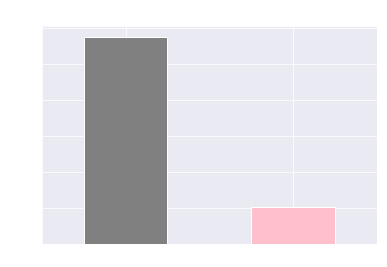

In [37]:
df.default.value_counts().plot(kind='bar', color=['grey', 'pink'])
ax = plt.title('Distribution of Loan Outcomes', fontsize=18, color='white')
ax = plt.xticks(np.arange(2), ('No Default', 'Default'), color='white', rotation=0)
ax = plt.yticks(color='white')
#ax = plt.ylabels('Counts', color='white')

plt.show()

In [38]:
df.default.value_counts()/len(df)

0    0.850386
1    0.149614
Name: default, dtype: float64

In [39]:
# drop name as it will not be useful for classification
df.drop(['Name', 'name2'], axis=1, inplace=True)

In [40]:
# drop 'REbacked' and 'medincome' due to high poss of multicollinearity (and weird results in 
# prior runs)
df.drop(['REbacked', 'medincome'], axis=1, inplace=True)

In [41]:
# dummy bankstate, state and sector
def makedummies(df, col):
    for c in col:
        dummy = pd.get_dummies(df[c], prefix=c, drop_first=True)
        #print(dummy)
        df = pd.concat([df, dummy], axis=1)
        df.drop(c, axis=1, inplace=True)
    return df


In [42]:
df = makedummies(df,['BankState', 'sector', 'MoApproved', 'county'])

In [43]:
df.shape

(33847, 151)

In [44]:
X = df.drop('default', axis=1)
y = df.default

In [45]:
# train test train_test_split. 
X_train, X_test, y_train, y_test = \
           train_test_split(X, y, \
                            random_state = 16, test_size = 0.3, stratify=y)

# standardize X VALUES using list of x variables
ss = StandardScaler()
Xs_train = pd.DataFrame(ss.fit_transform(X_train), columns=X.columns)
Xs_test = pd.DataFrame(ss.transform(X_test), columns=X.columns)

C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [54]:
# function to plot ROC curve for later
from sklearn.metrics import roc_curve

def plot_roc(y, probs, threshmarkers=None):
    fpr, tpr, thresh = roc_curve(y, probs)

    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, lw=2)
   
    plt.xlabel("False Positive Rate\n(1 - Specificity)")
    plt.ylabel("True Positive Rate\n(Sensitivity)")
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xticks(np.linspace(0, 1, 11), rotation=45)
    plt.yticks(np.linspace(0, 1, 11))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.show()


In [47]:
baseline = df[df.default==0].default.count()/len(df.default)

In [32]:
# function to run gridsearch cv on a variety of classification methods
def gscv(method, params, cv, Xtrain, ytrain, Xtest, ytest):
    gridsearcher = GridSearchCV(method, param_grid=params,cv=cv, verbose=4, n_jobs=-1)
    result = gridsearcher.fit(Xtrain, ytrain)

    print('Best cross-validated parameters:', result.best_params_)
    # this is the accuracy score ie. tp+tn/totpopn
    best = result.best_estimator_
    score = best.score(Xtest, ytest)
    print('{} Score {}'.format(method, score))
    # confusion matrix
    print('Confusion matrix: ', confusion_matrix(ytest, best.predict(Xtest)))
    # classification report
    print(classification_report(ytest, best.predict(Xtest)))
    # get AUC / ROC
    fpr, tpr, _ = roc_curve(ytest, best.predict_proba(Xtest)[:,1])
    roc_auc = auc(fpr, tpr)
    print('{} Classification AUC:'.format(method), roc_auc)
    recall = recall_score(ytest, best.predict(Xtest))
    print('Recall score: {}'.format(recall_score(ytest, best.predict(Xtest))))
    return best, score, roc_auc, recall


<div class="alert alert-block alert-info">
<b>1. Logistic Regression</b> 
</div>

In [14]:
# logistic regression param 
logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, num=5)
}

In [15]:
bestlr = gscv(LogisticRegression(), logr_parameters, 5, Xs_train, y_train, Xs_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.2min finished


Best cross-validated parameters: {'C': 13.0, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) Score 0.8859675036927622
Confusion matrix:  [[8428  208]
 [ 950  569]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      8636
           1       0.73      0.37      0.50      1519

   micro avg       0.89      0.89      0.89     10155
   macro avg       0.82      0.68      0.72     10155
weighted avg       0.87      0.89      0.87     10155

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_st

In [25]:
# get coefficients
logdf = pd.DataFrame(bestlr[0].coef_[0], index=X.columns, columns=['LR'])
logdf['LRabs'] = abs(logdf.LR)
# getting top features
logdf = logdf.sort_values(by='LRabs', ascending=False)
logdf[:20]

,LR,LRabs
BankState_PA,-3.069139,3.069139
NoEmp,-2.142657,2.142657
BankState_DE,-2.109942,2.109942
BankState_RI,-1.868940,1.868940
Term,-1.745316,1.745316
BankState_NY,-1.417975,1.417975
BankState_SD,-0.794943,0.794943
BankState_NJ,-0.744733,0.744733
BankState_NC,-0.688598,0.688598
BankState_MD,-0.642954,0.642954


<div class="alert alert-block alert-info">
<b> 3. Logistic Regression + Balanced Weights</b> 
</div>

In [17]:
bestlrbal = gscv(LogisticRegression(class_weight='balanced'), logr_parameters, 5, Xs_train, y_train, Xs_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.7min finished


Best cross-validated parameters: {'C': 25.0, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False) Score 0.779123584441162
Confusion matrix:  [[6669 1967]
 [ 276 1243]]
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      8636
           1       0.39      0.82      0.53      1519

   micro avg       0.78      0.78      0.78     10155
   macro avg       0.67      0.80      0.69     10155
weighted avg       0.87      0.78      0.81     10155

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose

In [26]:
# get coefficients
def coeff(logdf, method, X):
    name = method.replace('best', '').upper()
    glob = globals()[method]
    if 'rf' in method:
        temp = pd.DataFrame(glob[0].feature_importances_, index=X.columns, columns=[name])
    else:
        temp = pd.DataFrame(glob[0].coef_[0], index=X.columns, columns=[name])
    temp[name+'abs'] = abs(temp[name])
# join
    logdf = logdf.join(temp)
    return logdf

In [27]:
logdf = coeff(logdf, 'bestlrbal', X)


In [29]:
logdf.sort_values(by='LRBALabs', ascending=False)[:20]

,LR,LRabs,LRBAL,LRBALabs
BankState_PA,-3.069139,3.069139,-2.720251,2.720251
NoEmp,-2.142657,2.142657,-1.950210,1.950210
BankState_DE,-2.109942,2.109942,-1.845188,1.845188
BankState_RI,-1.868940,1.868940,-1.701393,1.701393
Term,-1.745316,1.745316,-1.388303,1.388303
BankState_NY,-1.417975,1.417975,-1.263893,1.263893
FYA90-94,-0.543685,0.543685,-0.687084,0.687084
BankState_SD,-0.794943,0.794943,-0.633529,0.633529
BankState_NJ,-0.744733,0.744733,-0.629784,0.629784
BankState_NC,-0.688598,0.688598,-0.608815,0.608815


<div class="alert alert-block alert-info">
<b> 10. Random Forest</b> 
</div>

In [48]:
ranf_parameters = {
    'n_estimators': [100, 200, 500, 800],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,6,8],
    'criterion' :['gini']
}

In [31]:
bestrf = gscv(RandomForestClassifier(), ranf_parameters, 5, Xs_train, \
                    y_train, Xs_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.4min finished


Best cross-validated parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) Score 0.8815361890694239
Confusion matrix:  [[8597   39]
 [1164  355]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      8636
           1       0.90      0.23      0.37      1519

   micro avg       0.88      0.88      0.88     10155
   macro avg       0.89      0.61      0.65     10155
weighted avg       0.88      0.88      0.85     10155

RandomForestClassifier(bootstrap=True, class_weight=None, 

In [32]:
logdf = coeff(logdf, 'bestrf', X)


In [49]:
bestrfbal = gscv(RandomForestClassifier(class_weight='balanced'), ranf_parameters, 5, Xs_train, \
                    y_train, Xs_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.0min finished


Best cross-validated parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False) Score 0.8664697193500739
Confusion matrix:  [[7621 1015]
 [ 341 1178]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      8636
           1       0.54      0.78      0.63      1519

   micro avg       0.87      0.87      0.87     10155
   macro avg       0.75      0.83      0.78     10155
weighted avg       0.89      0.87      0.88     10155

RandomForestClassifier(bootstrap=True, class_weight=

In [37]:
logdf = coeff(logdf, 'bestrfbal', X)

In [38]:
logdf.columns

Index(['LR', 'LRabs', 'LRBAL', 'LRBALabs', 'RF', 'RFabs', 'RFBAL', 'RFBALabs'], dtype='object')

In [40]:
logdf = logdf.sort_values(by='RFBALabs', ascending=False)
logdf[:20]

,LR,LRabs,LRBAL,LRBALabs,RF,RFabs,RFBAL,RFBALabs
Term,-1.745316,1.745316,-1.388303,1.388303,0.425129,0.425129,0.382227,0.382227
recession,-0.468973,0.468973,-0.572438,0.572438,0.116857,0.116857,0.135620,0.135620
FYA05-09,0.519968,0.519968,0.252882,0.252882,0.054926,0.054926,0.078114,0.078114
BankState_PA,-3.069139,3.069139,-2.720251,2.720251,0.047380,0.047380,0.047709,0.047709
RetainedJob,0.498619,0.498619,0.305674,0.305674,0.033130,0.033130,0.037221,0.037221
SBAgtee,0.219516,0.219516,0.201408,0.201408,0.027301,0.027301,0.031059,0.031059
GrAppv,0.280430,0.280430,0.450583,0.450583,0.028785,0.028785,0.030599,0.030599
FYA00-04,0.013007,0.013007,-0.316045,0.316045,0.024542,0.024542,0.027090,0.027090
UrbanRural,-0.054835,0.054835,-0.054878,0.054878,0.021466,0.021466,0.024412,0.024412
FYA90-94,-0.543685,0.543685,-0.687084,0.687084,0.012842,0.012842,0.023169,0.023169


In [41]:
logdf.to_pickle('./coefficients.pkl')

<div class="alert alert-block alert-info">
<b>5. SVM</b> 
</div>

In [42]:
svm_parameters = {
    'C': [0.01, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel':['rbf']
}


In [44]:
bestsvm = gscv(SVC(probability=True), svm_parameters, 5, Xs_train, y_train, Xs_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 160.0min finished


Best cross-validated parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False) Score 0.8958148695224027
Confusion matrix:  [[8320  316]
 [ 742  777]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      8636
           1       0.71      0.51      0.59      1519

   micro avg       0.90      0.90      0.90     10155
   macro avg       0.81      0.74      0.77     10155
weighted avg       0.89      0.90      0.89     10155

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False) Classification AUC: 0.8808405633017748
Recall score: 0.51

<div class="alert alert-block alert-info">
<b>12. SVM + Balanced Weights</b> 
</div>

In [45]:
bestsvmbal = gscv(SVC(class_weight='balanced', probability=True), svm_parameters, 5, Xs_train, y_train, Xs_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 68.7min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 195.0min finished


Best cross-validated parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False) Score 0.8560315115706548
Confusion matrix:  [[8236  400]
 [1062  457]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      8636
           1       0.53      0.30      0.38      1519

   micro avg       0.86      0.86      0.86     10155
   macro avg       0.71      0.63      0.65     10155
weighted avg       0.83      0.86      0.84     10155

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False) Classification AUC: 0.7938092178705366
Recall 

<div class="alert alert-block alert-info">
<b>6. Neural Networks</b> 
</div>

In [46]:
nn_parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant'],
}


In [47]:
bestnn = gscv(MLPClassifier(max_iter=100), nn_parameters, 5, Xs_train, \
             
                y_train, Xs_test, y_test)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.9min finished
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best cross-validated parameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) Score 0.8981782373215165
Confusion matrix:  [[8366  270]
 [ 764  755]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      8636
           1       0.74      0.50      0.59      1519

   micro avg       0.90      0.90      0.90     10155
   macro avg       0.83      0.73      0.77     10155
weighted avg       0.89      0.90      0.89     1

<div class="alert alert-block alert-info">
<b>7. NN + Balanced Weights</b> 
</div>

In [48]:
from sklearn.datasets import make_classification
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import RandomUnderSampler

In [49]:
# unf there is no built-in balanced weights option in MLPclassifier, so we'll have to undersample
# X instead (we have enough samples)

In [50]:
len(y_train[y_train==1])

3545

In [51]:
us_X, us_y = make_imbalance(Xs_train, y_train, ratio={1: 3545, 0: 3545},
                      random_state=0)
# rus = RandomUnderSampler(random_state=10)
# rus.fit(Xs_train, y_train)
# us_X, us_Y = rus.fit_sample(Xs_train, y_train)


C:\Users\schen24\Anaconda3\lib\site-packages\imblearn\datasets\_imbalance.py:105: UserWarning: 'ratio' has been deprecated in 0.4 and will be removed in 0.6. Use 'sampling_strategy' instead.
  warnings.warn("'ratio' has been deprecated in 0.4 and will be "


In [52]:
len(us_y)

7090

In [53]:
bestnnbal = gscv(MLPClassifier(max_iter=100), nn_parameters, 5, us_X, \
             
                us_y, Xs_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.3min finished
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best cross-validated parameters: {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) Score 0.7698670605612998
Confusion matrix:  [[6584 2052]
 [ 285 1234]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      8636
           1       0.38      0.81      0.51      1519

   micro avg       0.77      0.77      0.77     10155
   macro avg       0.67      0.79      0.68     10155
weighted avg       0.87      0.77      0.80     1

In [68]:
def modelresults(methods, baselines):
    zipped = list(zip(methods, baselines))
    results = pd.DataFrame(zipped, columns=['methods','baseline'])
    # create two new cols for score and auc 
    for row in results.index:
        x = globals()[results.loc[row,'methods']]
        results.loc[row, 'accuracy'] = x[1]
        results.loc[row, 'auc'] = x[2]
        results.loc[row,'recall'] = x[3]
    #results['scorediff'] = results.score-results.baseline
    results = results.sort_values(by='recall', ascending=False)
    results['methods'] = results['methods'].map(mdict)
    return results

In [69]:
methods = ['bestlr', 'bestlrbal', 'bestrf', 'bestrfbal','bestsvm', 'bestsvmbal', 'bestnn', 'bestnnbal']
mdict = {'bestlr':'Logistic Regression', 'bestlrbal':'Logistic Regression (Bal)', 'bestrf':'Random Forest', \
         'bestrfbal':'Random Forest (Bal)','bestsvm': 'Support Vector Machines', \
         'bestsvmbal':'Support Vector Machines (Bal)', 'bestnn':'Neural Networks', 'bestnnbal':'Neural Networks (Bal)'}
baselines = [baseline for n in methods]

In [70]:
results = modelresults(methods, baselines)
results = results[['methods', 'recall', 'auc', 'accuracy', 'baseline']]
results.sort_values(by='auc', ascending=False)

KeyError: 'bestlr'

Accuracy: 0.8664697193500739


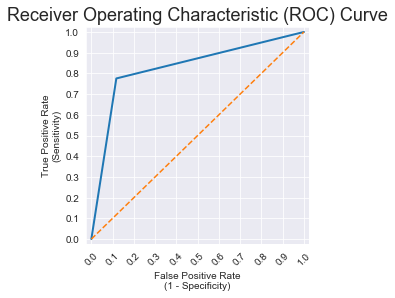

In [55]:
# plot roc curve and print accuracy
print('Accuracy:', bestrfbal[1])
plot_roc(y_test, bestrfbal[0].predict(Xs_test))

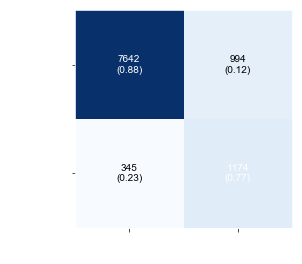

In [75]:
from mlxtend.plotting import plot_confusion_matrix
binary = np.array([[7642 , 994],
 [ 345 ,1174]])

fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False, cmap='Blues')
ax = plt.xlabel('Predicted', color='white')
ax = plt.ylabel('Actual', color='white')

ax = plt.xticks(np.arange(2), ('No Default', 'Default'), color='white')
ax = plt.yticks(np.arange(2), ('No Default', 'Default'), color='white')
#ax = plt.title('Confusion Matrix Results', color='skyblue')
plt.show()

In [71]:
#results = pd.read_pickle("./finalresults.pkl")
results.to_pickle('./finalresults.pkl')

Text(0.5,1,'2-class Precision-Recall curve')

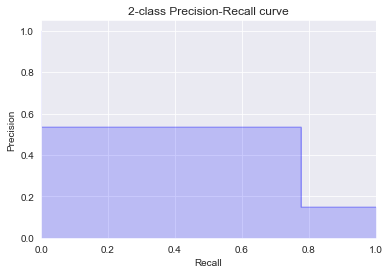

In [57]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, bestrfbal[0].predict(Xs_test))

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')